# Process All the Files


pip install opencv-python


# Stereo to depthmap conversion

In [6]:
import numpy as np
import cv2
import argparse
import sys

def depth_map(imgL, imgR):
    """ Depth map calculation. Works with SGBM and WLS. Need rectified images, returns depth map (left to right disparity) """
    window_size = 10  # Window size for SGBM
    min_disp = 0
    num_disp = 16 * 5  # Needs to be divisible by 16

    left_matcher = cv2.StereoSGBM_create(
        # minDisparity=min_disp,
        numDisparities=16,
        blockSize=window_size,
        P1=8 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)

    lmbda = 80000
    sigma = 1.5

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)

    displ = left_matcher.compute(imgL, imgR).astype(np.int16)
    dispr = right_matcher.compute(imgR, imgL).astype(np.int16)
    filtered_img = wls_filter.filter(displ, imgL, None, dispr)

    # Normalize the filtered disparity map for visualization
    filtered_img = cv2.normalize(filtered_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    filtered_img = np.uint8(filtered_img)

    return filtered_img

def parse_matrix_from_file(file_path, matrix_name):
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith(matrix_name):
                values = list(map(float, line.split(':')[1].strip().split()))
                return np.array(values).reshape((3, 4) if 'P' in matrix_name else (3, 3))
    raise ValueError(f"Matrix {matrix_name} not found in file {file_path}")

def parse_translation_vector(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('Tr_velo_to_cam'):
                values = list(map(float, line.split(':')[1].strip().split()))
                return np.array(values).reshape((3, 4))
    raise ValueError(f"Translation vector Tr_velo_to_cam not found in file {file_path}")

def disparity_to_depth(disparity, focal_length, baseline):
    """Convert disparity map to depth map."""
    with np.errstate(divide='ignore'):
        depth = (focal_length * baseline) / disparity
    depth[disparity == 0] = 0  # Mask out disparity values of 0 (infinite depth)
    return depth

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Stereo depth map')
    parser.add_argument('--calibration_file', type=str, required=True, help='Path to the calibration file')
    parser.add_argument('--left_image', type=str, required=True, help='Path to the left image')
    parser.add_argument('--right_image', type=str, required=True, help='Path to the right image')

    args = parser.parse_args()

    # Parse matrices from the calibration file
    P2 = parse_matrix_from_file(args.calibration_file, 'P2')
    P3 = parse_matrix_from_file(args.calibration_file, 'P3')
    R0_rect = parse_matrix_from_file(args.calibration_file, 'R0_rect')
    T = parse_translation_vector(args.calibration_file)

    K1 = P2[:, :3]
    K2 = P3[:, :3]
    R1 = R0_rect
    R2 = R0_rect
    P1 = P2
    P2 = P3

    # Extract focal length and baseline
    focal_length = K1[0, 0]  # Assuming fx is the same for both cameras
    baseline = np.linalg.norm(T[:, 3])  # Baseline is the norm of the translation vector

    # Read the images
    leftFrame = cv2.imread(args.left_image)
    rightFrame = cv2.imread(args.right_image)

    if leftFrame is None or rightFrame is None:
        print("Can't open the images!")
        sys.exit(-9)

    height, width, _ = leftFrame.shape

    # Generate rectification maps
    leftMapX, leftMapY = cv2.initUndistortRectifyMap(K1, None, R1, P1, (width, height), cv2.CV_32FC1)
    rightMapX, rightMapY = cv2.initUndistortRectifyMap(K2, None, R2, P2, (width, height), cv2.CV_32FC1)

    left_rectified = cv2.remap(leftFrame, leftMapX, leftMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
    right_rectified = cv2.remap(rightFrame, rightMapX, rightMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

    gray_left = cv2.cvtColor(left_rectified, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(right_rectified, cv2.COLOR_BGR2GRAY)

    disparity_image = depth_map(gray_left, gray_right)

    # Convert disparity map to depth map
    depth_image = disparity_to_depth(disparity_image, focal_length, baseline)

    cv2.imshow('left_rectified', left_rectified)
    cv2.imshow('right_rectified', right_rectified)
    cv2.imshow('Disparity', disparity_image)
    cv2.imshow('Depth', depth_image)

    cv2.waitKey(0)  # Wait for any key to be pressed
    cv2.destroyAllWindows()


usage: ipykernel_launcher.py [-h] --calibration_file CALIBRATION_FILE
                             --left_image LEFT_IMAGE --right_image RIGHT_IMAGE
ipykernel_launcher.py: error: the following arguments are required: --calibration_file, --left_image, --right_image


SystemExit: 2

/Users/adarshjohny/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Stereo to Disparity map

In [7]:
import numpy as np
import cv2
import argparse
import sys

def depth_map(imgL, imgR):
    """ Depth map calculation. Works with SGBM and WLS. Need rectified images, returns depth map (left to right disparity) """
    window_size = 5  # Window size for SGBM
    min_disp = 0
    num_disp = 16 * 5  # Needs to be divisible by 16

    left_matcher = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=window_size,
        P1=8 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)

    lmbda = 80000
    sigma = 1.5

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)

    displ = left_matcher.compute(imgL, imgR).astype(np.int16)
    dispr = right_matcher.compute(imgR, imgL).astype(np.int16)
    filtered_img = wls_filter.filter(displ, imgL, None, dispr)

    # Normalize the filtered disparity map for visualization
    filtered_img = cv2.normalize(filtered_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    filtered_img = np.uint8(filtered_img)

    return filtered_img

def parse_matrix_from_file(file_path, matrix_name):
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith(matrix_name):
                values = list(map(float, line.split(':')[1].strip().split()))
                return np.array(values).reshape((3, 4) if 'P' in matrix_name else (3, 3))
    raise ValueError(f"Matrix {matrix_name} not found in file {file_path}")

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Stereo depth map')
    parser.add_argument('--calibration_file', type=str, required=True, help='Path to the calibration file')
    parser.add_argument('--left_image', type=str, required=True, help='Path to the left image')
    parser.add_argument('--right_image', type=str, required=True, help='Path to the right image')

    args = parser.parse_args()

    # Parse matrices from the calibration file
    P2 = parse_matrix_from_file(args.calibration_file, 'P2')
    P3 = parse_matrix_from_file(args.calibration_file, 'P3')
    R0_rect = parse_matrix_from_file(args.calibration_file, 'R0_rect')

    K1 = P2[:, :3]
    K2 = P3[:, :3]
    R1 = R0_rect
    R2 = R0_rect
    P1 = P2
    P2 = P3

    # Read the images
    leftFrame = cv2.imread(args.left_image)
    rightFrame = cv2.imread(args.right_image)

    if leftFrame is None or rightFrame is None:
        print("Can't open the images!")
        sys.exit(-9)

    height, width, _ = leftFrame.shape

    # Generate rectification maps
    leftMapX, leftMapY = cv2.initUndistortRectifyMap(K1, None, R1, P1, (width, height), cv2.CV_32FC1)
    rightMapX, rightMapY = cv2.initUndistortRectifyMap(K2, None, R2, P2, (width, height), cv2.CV_32FC1)

    left_rectified = cv2.remap(leftFrame, leftMapX, leftMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
    right_rectified = cv2.remap(rightFrame, rightMapX, rightMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

    gray_left = cv2.cvtColor(left_rectified, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(right_rectified, cv2.COLOR_BGR2GRAY)

    disparity_image = depth_map(gray_left, gray_right)

    cv2.imshow('left_rectified', left_rectified)
    cv2.imshow('right_rectified', right_rectified)
    cv2.imshow('Disparity', disparity_image)

    cv2.waitKey(0)  # Wait for any key to be pressed
    cv2.destroyAllWindows()


usage: ipykernel_launcher.py [-h] --calibration_file CALIBRATION_FILE
                             --left_image LEFT_IMAGE --right_image RIGHT_IMAGE
ipykernel_launcher.py: error: the following arguments are required: --calibration_file, --left_image, --right_image


SystemExit: 2

In [ ]:
import cv2
import numpy as np
import os

# Load camera calibration data
def load_calib(calib_file):
    with open(calib_file, 'r') as f:
        lines = f.readlines()
        P0 = np.array([float(x) for x in lines[0].split(':')[1].strip().split()]).reshape(3, 4)
        P1 = np.array([float(x) for x in lines[1].split(':')[1].strip().split()]).reshape(3, 4)
        
        # Pad P0 with a bottom row of [0, 0, 0, 1] to make it 4x4
        P0 = np.vstack((P0, np.array([0, 0, 0, 1])))
    return P0, P1

def process_images(left_folder, right_folder, output_folder, calib_folder):
    # List all files in the left folder
    left_files = os.listdir(left_folder)

    for left_file in left_files:
        if left_file.endswith('.png'):
            # Form corresponding paths for left and right images and calibration data
            left_image_path = os.path.join(left_folder, left_file)
            right_image_path = os.path.join(right_folder, left_file)
            calib_file = os.path.join(calib_folder, left_file.replace('.png', '.txt'))

            # Load camera calibration data
            P0, P1 = load_calib(calib_file)

            # Load left and right images
            left_img = cv2.imread(left_image_path)
            right_img = cv2.imread(right_image_path)

            # Create a StereoSGBM object
            stereo = cv2.StereoSGBM_create(numDisparities=48, blockSize=1)

            # Compute the disparity map
            disparity = stereo.compute(left_img, right_img)

            # Reproject the disparity map to 3D space to obtain the depth map
            depth_map = cv2.reprojectImageTo3D(disparity, P0)

            # Save the depth map as a PNG file with the same name in the output folder
            output_file = os.path.join(output_folder, left_file.replace('.png', '_depth.png'))
            print("Saving depth map to:", output_file)
            success = cv2.imwrite(output_file, depth_map)
            if success:
                print("Depth map saved successfully.")
            else:
                print("Error: Unable to save depth map.")

# Paths for training and test datasets
train_left_folder = 'Project_Files/left/training'
train_right_folder = 'Project_Files/right/training'
train_output_folder = 'Project_Files/depth_images_local/training'
train_calib_folder = 'Project_Files/calib/training'

test_left_folder = 'Project_Files/left/testing'
test_right_folder = 'Project_Files/right/testing'
test_output_folder = 'Project_Files/depth_images_local/testing'
test_calib_folder = 'Project_Files/calib/testing'

# Process training images
process_images(train_left_folder, train_right_folder, train_output_folder, train_calib_folder)

# Process test images
process_images(test_left_folder, test_right_folder, test_output_folder, test_calib_folder)


In [ ]:
import cv2
import numpy as np
import glob
import os

# Function to load camera calibration parameters from a file
def load_calibration(calib_file):
    with open(calib_file, 'r') as f:
        params = f.readline().split()
        cam_mat = np.array([[float(params[0]), 0, float(params[2])], 
                            [0, float(params[1]), float(params[3])],
                            [0, 0, 1]])
        dist_coeff = np.array([float(params[4]), float(params[5]), float(params[6]), 
                               float(params[7]), float(params[8])])
    return cam_mat, dist_coeff

# Set up StereoSGBM
window_size = 5
min_disp = 0
num_disp = 192
stereo = cv2.StereoSGBM_create(minDisparity=min_disp,
                               numDisparities=num_disp,
                               blockSize=window_size,
                               P1=8 * 3 * window_size ** 2,
                               P2=32 * 3 * window_size ** 2,
                               disp12MaxDiff=1,
                               preFilterCap=63,
                               uniquenessRatio=10,
                               speckleWindowSize=100,
                               speckleRange=32,
                               mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)



# Paths to image folders
left_img_folders = ['./Project_Files/left/training']
right_img_folders = ['./Project_Files/right/training']
calib_folders = ['./Project_Files/calib/training']
output_dirs = ['./Project_Files/depth_output_2/training']

for left_folder, right_folder, calib_folder, output_dir in zip(left_img_folders, right_img_folders, calib_folders, output_dirs):
    left_imgs = sorted(glob.glob(os.path.join(left_folder, '*')))
    right_imgs = sorted(glob.glob(os.path.join(right_folder, '*')))
    calib_files = sorted(glob.glob(os.path.join(calib_folder, '*')))

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    for left, right, calib in zip(left_imgs, right_imgs, calib_files):
        img_left = cv2.imread(left, 0)
        img_right = cv2.imread(right, 0)

        # Load calibration parameters for the current image pair
        cam_mat, dist_coeff = load_calibration(calib)
        
        # Compute disparity
        disparity = stereo.compute(img_left, img_right).astype(np.float32) / 16.0
        
        # Reproject disparity to 3D
        depth = cv2.reprojectImageTo3D(disparity, cam_mat)
        
        # Normalize the depth map to the range [0, 255] for saving as an image
        depth_img = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX)
        depth_img = np.uint8(depth_img)
        
        # Save depth map
        output_path = os.path.join(output_dir, os.path.basename(left).replace('.png', '_depth.png'))
        cv2.imwrite(output_path, depth_img)

    print(f"Depth maps saved to {output_dir}")


In [1]:
import cv2
import numpy as np
import glob
import os

# Function to load the P1 and P2 matrices from a calibration file
def load_projection_matrices(calib_file):
    p1 = None
    p2 = None
    with open(calib_file, 'r') as f:
        for line in f:
            if line.startswith('P1:'):
                values = line.split()[1:]
                p1 = np.array([float(value) for value in values]).reshape(3, 4)
            elif line.startswith('P2:'):
                values = line.split()[1:]
                p2 = np.array([float(value) for value in values]).reshape(3, 4)
            if p1 is not None and p2 is not None:
                break
    if p1 is None or p2 is None:
        raise ValueError(f"P1 or P2 matrix not found in file: {calib_file}")
    return p1, p2

# Function to compute the Q matrix from P1 and P2
def compute_q_matrix(p1, p2):
    q = np.zeros((4, 4))
    q[0, 0] = 1
    q[1, 1] = 1
    q[0, 3] = -p1[0, 2]
    q[1, 3] = -p1[1, 2]
    q[2, 3] = p1[0, 0]
    q[3, 2] = -1 / (p2[0, 3] - p1[0, 3])
    q[3, 3] = (p1[0, 2] - p2[0, 2]) / (p2[0, 3] - p1[0, 3])
    return q

# Set up StereoSGBM
window_size = 5
min_disp = 0
num_disp = 192
stereo = cv2.StereoSGBM_create(minDisparity=0,
                               numDisparities=64,
                               blockSize=window_size,
                               P1=8 * 3 * window_size ** 2,
                               P2=32 * 3 * window_size ** 2,
                               disp12MaxDiff=1,
                               preFilterCap=63,
                               uniquenessRatio=10,
                               speckleWindowSize=100,
                               speckleRange=32,
                               mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)

# Paths to image folders
# Paths to image folders
left_img_folders = ['./Project_Files/left/training']
right_img_folders = ['./Project_Files/right/training']
calib_folders = ['./Project_Files/calib/training']
output_dirs = ['./Project_Files/depth_output_2/training']
for left_folder, right_folder, calib_folder, output_dir in zip(left_img_folders, right_img_folders, calib_folders, output_dirs):
    left_imgs = sorted(glob.glob(os.path.join(left_folder, '*')))
    right_imgs = sorted(glob.glob(os.path.join(right_folder, '*')))
    calib_files = sorted(glob.glob(os.path.join(calib_folder, '*')))

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    for left, right, calib in zip(left_imgs, right_imgs, calib_files):
        img_left = cv2.imread(left, 0)
        img_right = cv2.imread(right, 0)

        # Load the projection matrices P1 and P2 for the current image pair
        p1, p2 = load_projection_matrices(calib)
        
        # Compute the Q matrix from P1 and P2
        q_matrix = compute_q_matrix(p1, p2)
        
        # Compute disparity
        disparity = stereo.compute(img_left, img_right).astype(np.float32) / 16.0
        
        # Reproject disparity to 3D
        depth = cv2.reprojectImageTo3D(disparity, q_matrix)
        
        # Normalize the depth map to the range [0, 255] for saving as an image
        depth_img = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX)
        depth_img = np.uint8(depth_img)
        
        # Save depth map
        output_path = os.path.join(output_dir, os.path.basename(left).replace('.png', '_depth.png'))
        cv2.imwrite(output_path, depth_img)

    print(f"Depth maps saved to {output_dir}")


Depth maps saved to ./Project_Files/depth_output_2/training


/var/folders/py/ykskjld540vc_56ctk4d3nww0000gn/T/ipykernel_94856/73952677.py:84: RuntimeWarning: invalid value encountered in cast
  depth_img = np.uint8(depth_img)


# Adarsh May 27

In [2]:
# Original Matlab code https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html
#
#
# Python port of depth filling code from NYU toolbox
# Speed needs to be improved
#
# Uses 'pypardiso' solver 
#
import skimage
import scipy
import numpy as np
from scipy.sparse.linalg import spsolve
from PIL import Image

#
# fill_depth_colorization.m
# Preprocesses the kinect depth image using a gray scale version of the
# RGB image as a weighting for the smoothing. This code is a slight
# adaptation of Anat Levin's colorization code:
#
# See: www.cs.huji.ac.il/~yweiss/Colorization/
#
# Args:
#  imgRgb - HxWx3 matrix, the rgb image for the current frame. This must
#      be between 0 and 1.
#  imgDepth - HxW matrix, the depth image for the current frame in
#       absolute (meters) space.
#  alpha - a penalty value between 0 and 1 for the current depth values.

def fill_depth_colorization(imgRgb=None, imgDepthInput=None, alpha=1):
	imgIsNoise = imgDepthInput == 0
	maxImgAbsDepth = np.max(imgDepthInput)
	imgDepth = imgDepthInput / maxImgAbsDepth
	imgDepth[imgDepth > 1] = 1
	(H, W) = imgDepth.shape
	numPix = H * W
	indsM = np.arange(numPix).reshape((W, H)).transpose()
	knownValMask = (imgIsNoise == False).astype(int)
	grayImg = skimage.color.rgb2gray(imgRgb)
	winRad = 1
	len_ = 0
	absImgNdx = 0
	len_window = (2 * winRad + 1) ** 2
	len_zeros = numPix * len_window

	cols = np.zeros(len_zeros) - 1
	rows = np.zeros(len_zeros) - 1
	vals = np.zeros(len_zeros) - 1
	gvals = np.zeros(len_window) - 1

	for j in range(W):
		for i in range(H):
			nWin = 0
			for ii in range(max(0, i - winRad), min(i + winRad + 1, H)):
				for jj in range(max(0, j - winRad), min(j + winRad + 1, W)):
					if ii == i and jj == j:
						continue

					rows[len_] = absImgNdx
					cols[len_] = indsM[ii, jj]
					gvals[nWin] = grayImg[ii, jj]

					len_ = len_ + 1
					nWin = nWin + 1

			curVal = grayImg[i, j]
			gvals[nWin] = curVal
			c_var = np.mean((gvals[:nWin + 1] - np.mean(gvals[:nWin+ 1])) ** 2)

			csig = c_var * 0.6
			mgv = np.min((gvals[:nWin] - curVal) ** 2)
			if csig < -mgv / np.log(0.01):
				csig = -mgv / np.log(0.01)

			if csig < 2e-06:
				csig = 2e-06

			gvals[:nWin] = np.exp(-(gvals[:nWin] - curVal) ** 2 / csig)
			gvals[:nWin] = gvals[:nWin] / sum(gvals[:nWin])
			vals[len_ - nWin:len_] = -gvals[:nWin]

	  		# Now the self-reference (along the diagonal).
			rows[len_] = absImgNdx
			cols[len_] = absImgNdx
			vals[len_] = 1  # sum(gvals(1:nWin))

			len_ = len_ + 1
			absImgNdx = absImgNdx + 1

	vals = vals[:len_]
	cols = cols[:len_]
	rows = rows[:len_]
	A = scipy.sparse.csr_matrix((vals, (rows, cols)), (numPix, numPix))

	rows = np.arange(0, numPix)
	cols = np.arange(0, numPix)
	vals = (knownValMask * alpha).transpose().reshape(numPix)
	G = scipy.sparse.csr_matrix((vals, (rows, cols)), (numPix, numPix))

	A = A + G
	b = np.multiply(vals.reshape(numPix), imgDepth.flatten('F'))

	#print ('Solving system..')

	new_vals = spsolve(A, b)
	new_vals = np.reshape(new_vals, (H, W), 'F')

	#print ('Done.')

	denoisedDepthImg = new_vals * maxImgAbsDepth
    
	output = denoisedDepthImg.reshape((H, W)).astype('float32')

	output = np.multiply(output, (1-knownValMask)) + imgDepthInput
    
	return output


In [13]:

def depth_map_fn(imgL, imgR, numDisparities, blockSize, preFilterCap, uniquenessRatio, speckleWindowSize, speckleRange, disp12MaxDiff, minDisparity):
    """ Depth map calculation with dynamic parameters. """
    left_matcher = cv2.StereoSGBM_create(
        minDisparity=minDisparity,
        numDisparities=numDisparities,
        blockSize=blockSize,
        P1=8 * 3 * blockSize ** 2,
        P2=32 * 3 * blockSize ** 2,
        disp12MaxDiff=disp12MaxDiff,
        uniquenessRatio=uniquenessRatio,
        speckleWindowSize=speckleWindowSize,
        speckleRange=speckleRange,
        preFilterCap=preFilterCap,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)

    lmbda = 80000
    sigma = 1.5

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)

    displ = left_matcher.compute(imgL, imgR).astype(np.int16)
    dispr = right_matcher.compute(imgR, imgL).astype(np.int16)
    filtered_img = wls_filter.filter(displ, imgL, None, dispr)

    # # Normalize the filtered disparity map for visualization
    filtered_img = cv2.normalize(filtered_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    filtered_img = np.uint8(filtered_img)

    return filtered_img

def parse_matrix_from_file(file_path, matrix_name):
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith(matrix_name):
                values = list(map(float, line.split(':')[1].strip().split()))
                return np.array(values).reshape((3, 4) if 'P' in matrix_name else (3, 3))
    raise ValueError(f"Matrix {matrix_name} not found in file {file_path}")

def parse_translation_vector(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('Tr_velo_to_cam'):
                values = list(map(float, line.split(':')[1].strip().split()))
                return np.array(values).reshape((3, 4))
    raise ValueError(f"Translation vector Tr_velo_to_cam not found in file {file_path}")

def disparity_to_depth(disparity, focal_length, baseline):
    """Convert disparity map to depth map."""
    with np.errstate(divide='ignore'):
        depth = (focal_length * baseline) / disparity
    depth[disparity == 0] = 0  # Mask out disparity values of 0 (infinite depth)
    return depth

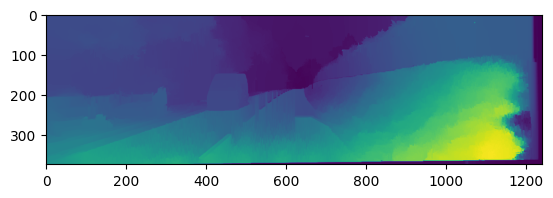

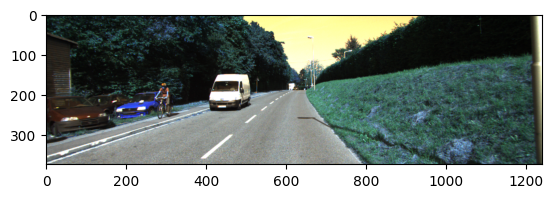

Saving depth map to: ./Project_Files/May_27_1/000792_depth.png
Depth map saved successfully.


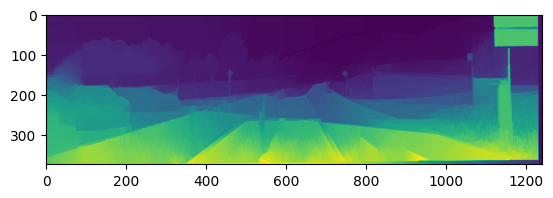

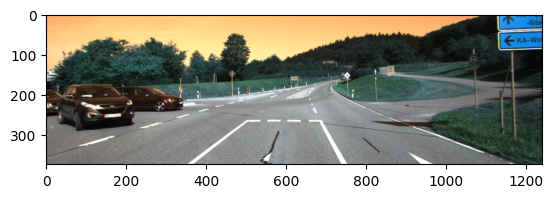

Saving depth map to: ./Project_Files/May_27_1/000001_depth.png
Depth map saved successfully.


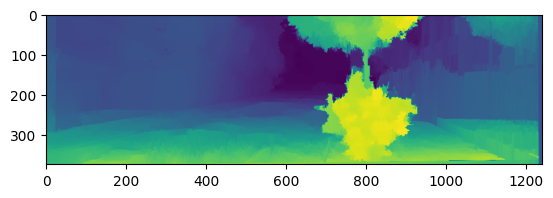

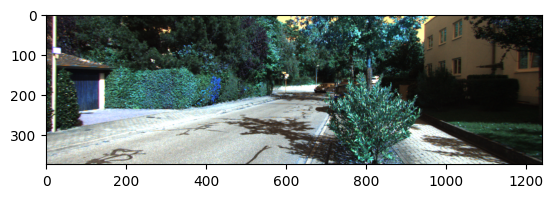

Saving depth map to: ./Project_Files/May_27_1/000000_depth.png
Depth map saved successfully.


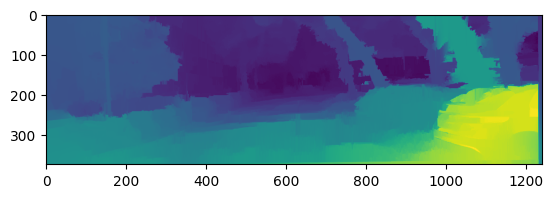

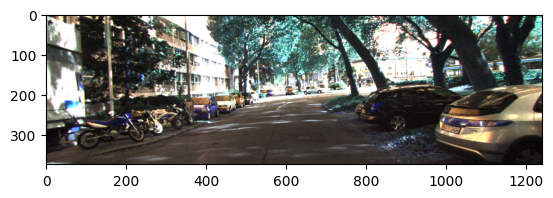

Saving depth map to: ./Project_Files/May_27_1/000002_depth.png
Depth map saved successfully.


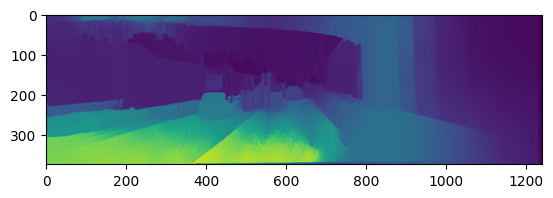

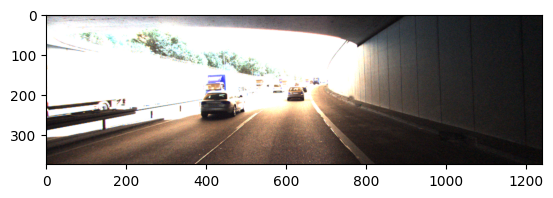

Saving depth map to: ./Project_Files/May_27_1/000003_depth.png
Depth map saved successfully.


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
base_folder = "./"
# Load camera calibration data
def load_calib(calib_file):
    with open(calib_file, 'r') as f:
        lines = f.readlines()
        P0 = np.array([float(x) for x in lines[0].split(':')[1].strip().split()]).reshape(3, 4)
        P1 = np.array([float(x) for x in lines[1].split(':')[1].strip().split()]).reshape(3, 4)
        
        # Pad P0 with a bottom row of [0, 0, 0, 1] to make it 4x4
        P0 = np.vstack((P0, np.array([0, 0, 0, 1])))
    return P0, P1
def process_images(left_folder, right_folder, output_folder, calib_folder):
    # List all files in the left folder
    left_files = os.listdir(left_folder)
    for left_file in left_files:
        if left_file.endswith('.png'):
            # Form corresponding paths for left and right images and calibration data
            left_image_path = os.path.join(left_folder, left_file)
            right_image_path = os.path.join(right_folder, left_file)
            calibration_file_path = os.path.join(calib_folder, left_file.replace('.png', '.txt'))
            
            # Parse matrices from the calibration file
            P2 = parse_matrix_from_file(calibration_file_path, 'P2')
            P3 = parse_matrix_from_file(calibration_file_path, 'P3')
            R0_rect = parse_matrix_from_file(calibration_file_path, 'R0_rect')
            T = parse_translation_vector(calibration_file_path)

            K1 = P2[:, :3]
            K2 = P3[:, :3]
            R1 = R0_rect
            R2 = R0_rect

            # Extract focal length and baseline
            focal_length = K1[0, 0]  # Assuming fx is the same for both cameras
            baseline = np.linalg.norm(T[:, 3])  # Baseline is the norm of the translation vector

            # Read the images
            left_image = cv2.imread(left_image_path)
            right_image = cv2.imread(right_image_path)

            if left_image is None or right_image is None:
                print(f"Can't open images: {left_image_path}, {right_image_path}")
                continue

            height, width, _ = left_image.shape

            # Generate rectification maps
            leftMapX, leftMapY = cv2.initUndistortRectifyMap(K1, None, R1, P2, (width, height), cv2.CV_32FC1)
            rightMapX, rightMapY = cv2.initUndistortRectifyMap(K2, None, R2, P3, (width, height), cv2.CV_32FC1)

            left_rectified = cv2.remap(left_image, leftMapX, leftMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
            right_rectified = cv2.remap(right_image, rightMapX, rightMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

            gray_left = cv2.cvtColor(left_rectified, cv2.COLOR_BGR2GRAY)
            gray_right = cv2.cvtColor(right_rectified, cv2.COLOR_BGR2GRAY)

            # Set default parameters for depth map calculation
            numDisparities = 16 * 6
            blockSize = 11
            preFilterCap = 31
            uniquenessRatio = 15
            speckleWindowSize = 200
            speckleRange = 2
            disp12MaxDiff = 1
            minDisparity = 0

            disparity_image = depth_map_fn(gray_left, gray_right, numDisparities, blockSize, preFilterCap, uniquenessRatio, speckleWindowSize, speckleRange, disp12MaxDiff, minDisparity)
            
            output_file = os.path.join(output_folder, left_file.replace('.png', '___.png'))
            
            cv2.imwrite(output_file, disparity_image)

            
            colored_dispartiy = fill_depth_colorization(left_image,disparity_image)
        
         
            plt.imshow(colored_dispartiy)
            plt.show()
            
            plt.imshow(left_image)
            plt.show()

            # Save the depth map as a PNG file with the same name in the output folder
            output_file = os.path.join(output_folder, left_file.replace('.png', '_depth.png'))
            print("Saving depth map to:", output_file)
            success = cv2.imwrite(output_file, colored_dispartiy)
            if success:
                print("Depth map saved successfully.")
            else:
                print("Error: Unable to save depth map.")


# Paths for training and test datasets
train_left_folder = base_folder+'Project_Files/left/training'
train_right_folder = base_folder+'Project_Files/right/training'
train_output_folder =  base_folder+'Project_Files/May_27_1'
train_calib_folder = base_folder+ 'Project_Files/calib/training'


# Process training images
process_images(train_left_folder, train_right_folder, train_output_folder, train_calib_folder)